Denoising fMRI data and functional connectivity estimation
================================================

This is an example script for denoising and FC estimation from fMRI (1 subject) on data preprocessed in fmriprep with `--use-aroma` flag.


Step 1: Importing packages
------------------------------------------

In [11]:
%reset
%matplotlib inline

from os import listdir

import pandas as pd
import numpy as np # the Python array package
import matplotlib.pyplot as plt  # the Python plotting package

from nilearn import datasets
from nilearn import plotting
from nilearn import input_data
from nilearn import signal
from nilearn.input_data import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure
import nibabel as nib


Once deleted, variables cannot be recovered. Proceed (y/[n])? y


Step 2: Creating atlas
-------------------------------------------

In [12]:
# Loading Power ROIs coordinates

power = datasets.fetch_coords_power_2011()
power_coords = np.vstack((power.rois['x'], power.rois['y'], power.rois['z'])).T

# Creating masker file

power_spheres = input_data.NiftiSpheresMasker(
    seeds = power_coords, 
    #smoothing_fwhm = 6, 
    radius = 5,
    standardize = True
)

Step 3: Loading data
-----------------------

In [237]:
# Loading functional data
top_dir = '/home/finc/Downloads/fmriprep/'

sub = 'sub-01'
ses = 'ses-1'
task = 'dualnback'

sub_dir = top_dir + sub + '/' + ses + '/func/'

#suffix = 'space-MNI152NLin2009cAsym_preproc.nii.gz'
suffix = 'space-MNI152NLin2009cAsym_variant-smoothAROMAnonaggr_preproc.nii.gz'

dual_data = sub_dir + sub + '_' + ses + '_task-' + task + '_bold_' + suffix


In [238]:
# Loading confound data

confounds_path = sub_dir + sub + '_' + ses + '_task-' + task + '_bold_confounds.tsv'
confounds = pd.read_csv(confounds_path, delimiter = '\t')

confounds_clean = confounds[['CSF', 'WhiteMatter']]
confounds_clean['LinearTrend'] = list(range(1,341))


confounds_clean.to_csv(sub_dir + 'confounds_' + task + '_clean_aroma.csv', sep = ',', index = False)

confounds_clean_path = sub_dir + 'confounds_' + task + '_clean_aroma.csv'

/home/finc/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


Step 4: Extracting timeseries
-----------------------------------------------

In [240]:
timeseries_power = power_spheres.fit_transform(dual_data, confounds = confounds_clean_path)

timeseries_power_filtered = signal.clean(timeseries_power,     
    low_pass = 0.08, 
    high_pass = 0.009)

timeseries_power_filtered.shape 

(340, 264)

Step 5: Calculating correlation matrix
--------------------------------------------------------------

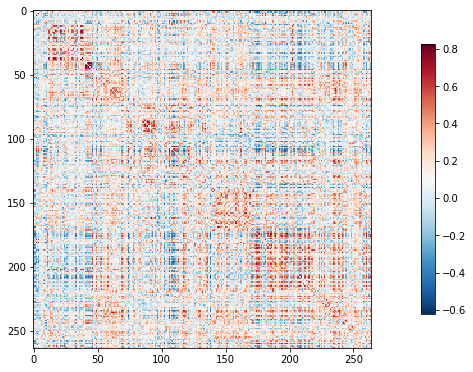

In [241]:
# Calculating static FC matrix

correlation_measure = ConnectivityMeasure(kind = 'correlation')
fc_power = correlation_measure.fit_transform([timeseries_power_filtered])[0]

# Make a large figure
# Mask the main diagonal for visualization:
np.fill_diagonal(fc_power, 0)

# The labels we have start with the background (0), hence we skip the
# first label
# matrices are ordered for block-like representation
plotting.plot_matrix(fc_power)

In [51]:
np.save(sub_dir + sub + '_timeseries.npy', timeseries_power_filtered)

Step 6: Dividing timeseries to task conditions
-----------------------------------------------------------

In [13]:
onsets_1back = np.array([4, 72, 140, 208, 276, 344, 412, 480, 548, 616])
onsets_2back = np.array([38, 106, 174, 242, 310, 378, 446, 514, 582, 650])
vol_num = 340

TR = 2
duration = 30

vector_n_back = np.zeros((vol_num, 3))

for i in range(len(vector_n_back)):
    if i in onsets_1back/TR:
        for k in range(int(duration/TR)):
            vector_n_back[i + k, 0] = 1
    if i in onsets_2back/TR:
        for k in range(int(duration/TR)):
            vector_n_back[i + k, 1] = 1
    else:
        continue
        
            
for i in range(len(vector_n_back)):
    if vector_n_back[i,0] == 0 and vector_n_back[i,1] == 0:
        vector_n_back[i,2] = 1
        
dual1back = vector_n_back[:,0].astype(bool)
dual2back = vector_n_back[:,1].astype(bool)

In [85]:
timeseries_power_filtered.shape 

(340, 264)

In [96]:
timeseries_dual1back = timeseries_power_filtered[dual1back,:]
timeseries_dual2back = timeseries_power_filtered[dual2back,:]

In [93]:
timeseries_power_filtered[1,1]

1.2424770882376519

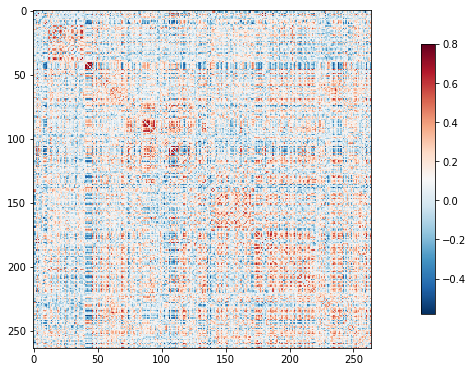

In [100]:
# 1 back
correlation_measure = ConnectivityMeasure(kind = 'correlation')
fc_power = correlation_measure.fit_transform([timeseries_dual1back])[0]

# Make a large figure
# Mask the main diagonal for visualization:
np.fill_diagonal(fc_power, 0)

# The labels we have start with the background (0), hence we skip the
# first label
# matrices are ordered for block-like representation
plotting.plot_matrix(fc_power, vmax = 0.8)

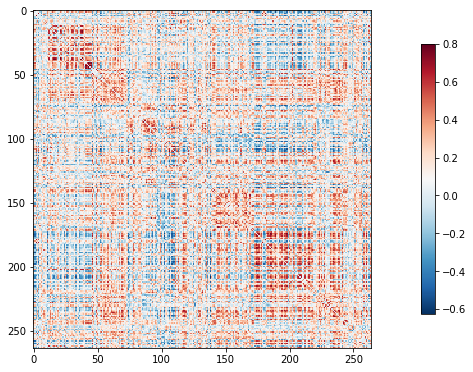

In [101]:
# 1 back
correlation_measure = ConnectivityMeasure(kind = 'correlation')
fc_power = correlation_measure.fit_transform([timeseries_dual2back])[0]

# Make a large figure
# Mask the main diagonal for visualization:
np.fill_diagonal(fc_power, 0)

# The labels we have start with the background (0), hence we skip the
# first label
# matrices are ordered for block-like representation
plotting.plot_matrix(fc_power, vmax = 0.8)

Step 7: Looping
---------------------------

In [14]:
# Loading functional data
top_dir = '/home/finc/Downloads/fmriprep/'

subs = listdir(top_dir)
#subs = ['sub-01', 'sub-02', 'sub-05']
sess = ['ses-1', 'ses-2', 'ses-3', 'ses-4']
tasks = ['dualnback']
suffix = 'space-MNI152NLin2009cAsym_variant-smoothAROMAnonaggr_preproc.nii.gz'


In [ ]:
timeseries_all = np.zeros((len(subs), len(sess), len(tasks), 340, 264))

for sub in range(len(subs)):
    for ses in range(len(sess)):
        for task in range(len(tasks)):
            sub_dir = top_dir + subs[sub] + '/' + sess[ses] + '/func/'
            dual_data = sub_dir + subs[sub] + '_' + sess[ses] + '_task-' + tasks[task] + '_bold_' + suffix
            
            confounds_path = sub_dir + subs[sub] + '_' + sess[ses] + '_task-' + tasks[task] + '_bold_confounds.tsv'
            confounds = pd.read_csv(confounds_path, delimiter = '\t')

            confounds_clean = confounds[['CSF', 'WhiteMatter']]
            confounds_clean['LinearTrend'] = list(range(1,341))
            confounds_clean.to_csv(sub_dir + subs[sub] + '_' + sess[ses] + '_task-' + tasks[task] + '_confounds_clean_aroma.csv', sep = ',', index = False)
            confounds_clean_path = sub_dir + subs[sub] + '_' + sess[ses] + '_task-' + tasks[task] + '_confounds_clean_aroma.csv'
            
            timeseries_power = power_spheres.fit_transform(dual_data, confounds = confounds_clean_path)
            timeseries_power_filtered = signal.clean(timeseries_power, low_pass = 0.08, high_pass = 0.009)
            
            timeseries_all[sub, ses, task, :, :] = timeseries_power_filtered   

/home/finc/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [250]:
correlarion_matrices_dual = np.zeros((len(subs), len(sess), 2, 264, 264))


for sub in range(len(timeseries_all[:, 0, 0, 0, 0])):
    for ses in range(len(timeseries_all[0,:,0,0,0])):                 
        timeseries_dual1back = timeseries_all[sub, ses, 0, dual1back, :]
        timeseries_dual2back = timeseries_all[sub, ses, 0, dual2back, :]
        
        correlation_measure = ConnectivityMeasure(kind = 'correlation')
        fc1 = correlation_measure.fit_transform([timeseries_dual1back])[0]
        np.fill_diagonal(fc1, 0)
        
        fc2 = correlation_measure.fit_transform([timeseries_dual2back])[0]
        np.fill_diagonal(fc2, 0)
                     
        correlarion_matrices_dual[sub, ses, 0, :, :] = fc1
        correlarion_matrices_dual[sub, ses, 1, :, :] = fc2


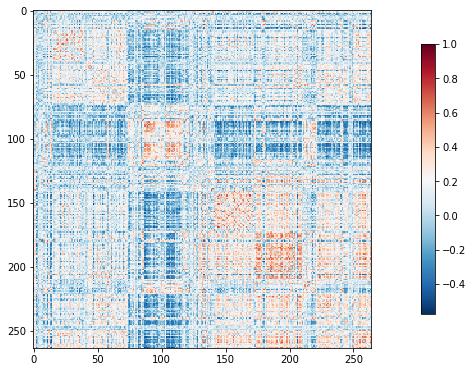

In [259]:
plotting.plot_matrix(correlarion_matrices_dual[2, 2, 1, :, :], vmax = 1)